# Questão 1
## Estruturação Conceitual – Modelagem de Risco de Diabetes

Este trecho corresponde a Questão 1, dos tópicos referentes a fundamentação tecnica, para compreensão do problema, os principais desafios e as ferramentas empregadas.
### Q1.A: Etapas para compreender o problema
#### Introdução ao Problema e Justificativa de Aprendizado Supervisionado
Utilizamos **Machine Learning supervisionado** para construir um modelo preditivo de diagnóstico de diabetes.  
- **Por que supervisionado?**  
  A base de dados já contém uma **variável-alvo** (o diagnóstico de diabetes: 0 = não diabético, 1 = diabético) e uma série de **features**. Como o objetivo é **aprender** a relação entre essas variáveis de entrada e o diagnóstico, faz sentido treinar um modelo que receba as features e **preveja** o target. Em contraste, em aprendizado não-supervisionado não há variável-alvo conhecida a priori, e o foco seria em clusterização ou redução de dimensionalidade — o que não corresponde à nossa tarefa de classificação médica.

### Q1.B: Porque o problema se enquadra em uma classificação supervisionada
A predição de risco de diabetes configura-se naturalmente como tarefa de **classificação supervisionada** pelos seguintes motivos:

1. **Presença de rótulo binário**: a variável-alvo Diabetes_binary assume valores 0 (sem diagnóstico) ou 1 (diagnosticado), permitindo treinar o modelo com exemplos classificados.

2. **Disponibilidade de atributos explicativos**: indicadores clínicos (IMC, pressão arterial, colesterol), histórico de saúde cardiovascular e comportamentais (dieta, atividade física) formam variáveis de entrada que descrevem cada indivíduo.

3. **Objetivo de generalização**: espera-se que o modelo aprenda padrões nos dados rotulados e aplique esse conhecimento para prever o diagnóstico de novos entrevistados.


### Q1.C: Desafios Técnicos

### 2.1 Desequilíbrio de Classes
Em amostras populacionais, há proporção muito maior de casos negativos. Sem tratamento adequado, o classificador tende a ignorar a classe minoritária.
- **Solução**: uso de class_weight='balanced', reamostragem (SMOTE/undersampling) ou métricas focadas (F1-score, AUC-ROC).

### 2.2 Heterogeneidade de Escalas
Variáveis em diferentes unidades (ex.: IMC em kg/m², idade em anos) podem distorcer modelos sensíveis a magnitude.
- **Solução**: padronização via StandardScaler ou escala Min–Max.

---

## Q1.D: Principais Bibliotecas

- **NumPy**  
  - Biblioteca fundamental para computação numérica em Python.  
  - Usada para operações vetoriais e manipulação eficiente de arrays  
  - Exemplo de uso: `np.array(...)`, calcula estatísticas como média e desvio padrão dos dados.

- **Pandas**  
  - Facilita a leitura e manipulação de tabelas (DataFrames).  
  - Usada para importar a base de dados, explorar estatísticas descritivas e tratar valores faltantes.  
  - Exemplo de uso: `pd.read_csv(...)`, `df.describe()`, `df.isnull().sum()`.

- **Scikit-Learn**  
  - Fornece as ferramentas de pré-processamento, modelagem e validação.  
  - **`train_test_split`**: divide os dados em conjunto de treino e teste com estratificação.  
  - **`StandardScaler`**: normaliza features para média zero e variância unitária, fundamental para métodos baseados em distância (como KNN).  
  - **`Pipeline`**: encadeia etapas de pré-processamento e modelo em um único objeto.  
  - **`KNeighborsClassifier`**: algoritmo de classificação baseado em vizinhança, que escolhe a classe com maior ocorrência entre os K vizinhos mais próximos.  
  - **`GridSearchCV`**: pesquisa exaustiva por hiperparâmetros usando validação cruzada.

- **Matplotlib / Seaborn**  
  - Geram visualizações gráficas para explorar a distribuição dos dados e avaliar métricas de desempenho (ROC, matriz de confusão etc.).


# 4. Estrutura do Experimento

1. **Carregamento e Exploração**  
   - Importação da base e estatísticas descritivas iniciais.  
   - Verificação de valores ausentes e outliers.

2. **Divisão Treino/Teste**  
   - Uso de `train_test_split(..., stratify=y, test_size=0.2)` para garantir proporção consistente de classes.

3. **Pré-processamento**  
   - Normalização com `StandardScaler` dentro de um `Pipeline`.

4. **Modelagem Inicial**  
   - Treinamento de um `KNeighborsClassifier` com valores padrão de K e métrica Euclidiana.

5. **Validação Cruzada e Ajuste de Hiperparâmetros**  
   - Aplicação de `GridSearchCV` para avaliar diferentes valores de K e esquemas de ponderação (`uniform`, `distance`).

6. **Avaliação Final**  
   - Cálculo de métricas de test set: precision, recall, F1-score.  
   - Curva ROC e AUC.  
   - Matriz de confusão para discutir falsos positivos e falsos negativos.



In [4]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [5]:
cdc = fetch_ucirepo(id=891)
X = cdc.data.features
y = cdc.data.targets.squeeze()
df = pd.concat([X, y.rename('Diabetes_binary')], axis=1)

# --- Inspeção inicial ---

# 1) Primeiras 5 linhas
print("=== Primeiras 5 linhas ===")
print(df.head())

# 2) Informações gerais (tipos e contagem de não nulos)
print("\n=== Informações gerais ===")
print(df.info())

# 3) Valores ausentes por coluna
print("\n=== Contagem de valores ausentes ===")
print(df.isna().sum())


=== Primeiras 5 linhas ===
   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1   28       0       0                     0   
3       1         0          1   27       0       0                     0   
4       1         1          1   24       0       0                     0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  \
0             0       0        1                  0              1   
1             1       0        0                  0              0   
2             0       1        0                  0              1   
3             1       1        1                  0              1   
4             1       1        1                  0              1   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  \
0          

## Resumo do Diagnóstico Inicial dos Dados

1. **Ausência de dados faltantes**  
   - Todas as 22 variáveis têm 100% de valores não-nulos  
   - _Imputação não necessária nesta etapa_

2. **Escalonamento das variáveis**  
   - Features com amplitudes distintas (e.g. BMI vs. variáveis binárias)  
   - **Solução**: aplicar StandardScaler ou MinMaxScaler  

3. **Desequilíbrio de classes**  
   - ≈ 86% de “não-diabetes” vs. ≈ 14% de “diabetes”  
   - **Soluções**:  
     - train_test_split(stratify=y)  
     - usar class_weight='balanced'  
     - reamostragem: SMOTE (oversampling) ou undersampling  

4. **Multicolinearidade e variância baixa**  
   - Possível correlação alta entre variáveis clínicas  
   - Certaines features podem ter variância reduzida  
   - **Soluções**:  
     - VarianceThreshold para remover baixa variância  
     - análise de correlação e remoção de pares altamente correlacionados  



=== Contagem de cada classe ===
Diabetes_binary
Não diagnosticado (0)    218334
Diagnosticado (1)         35346
Name: count, dtype: int64

=== Proporção de cada classe (%) ===
Diabetes_binary
Não diagnosticado (0)    86.07
Diagnosticado (1)        13.93
Name: proportion, dtype: float64


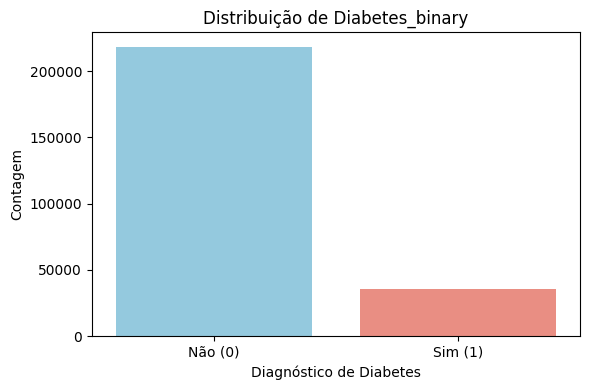

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4) Análise de distribuição de classes e proporção de casos

# a) Contagem absoluta e percentual
counts = df['Diabetes_binary'].value_counts()
percent = df['Diabetes_binary'].value_counts(normalize=True) * 100

print("=== Contagem de cada classe ===")
print(counts.rename({0: 'Não diagnosticado (0)', 1: 'Diagnosticado (1)'}))

print("\n=== Proporção de cada classe (%) ===")
print(percent.rename({0: 'Não diagnosticado (0)', 1: 'Diagnosticado (1)'}).round(2))

# b) Gráfico de barras
plt.figure(figsize=(6,4))
sns.countplot(
    x='Diabetes_binary',
    hue='Diabetes_binary',
    data=df,
    palette={0: 'skyblue', 1: 'salmon'},
    legend=False
)
plt.xticks([0,1], ['Não (0)','Sim (1)'])
plt.title('Distribuição de Diabetes_binary')
plt.ylabel('Contagem')
plt.xlabel('Diagnóstico de Diabetes')
plt.tight_layout()
plt.show()


## Análise de Distribuição de Classes

- **Desequilíbrio acentuado**  
  - Não diagnosticados (0): 218 334 (~86 %)  
  - Diagnosticados (1):  35 346 (~14 %)

- **Riscos**  
  - Modelo pode “chutar” sempre a classe majoritária e obter ~86 % de acurácia sem aprender de fato  
  - Falsos negativos têm alto custo em triagem de diabetes

- **Ações Necessarias**  
  1. **Split estratificado**  
     - train_test_split(..., stratify=y) para manter proporções de classes  
  2. **Reamostragem**  
     - **Oversampling** (SMOTE) ou **undersampling** da classe majoritária  
  3. **Ajuste de pesos**  
     - class_weight='balanced' em modelos que suportem  
  4. **Métricas focadas**  
     - Priorizar F1‐score (classe 1), recall e AUC‐ROC em vez de acurácia bruta


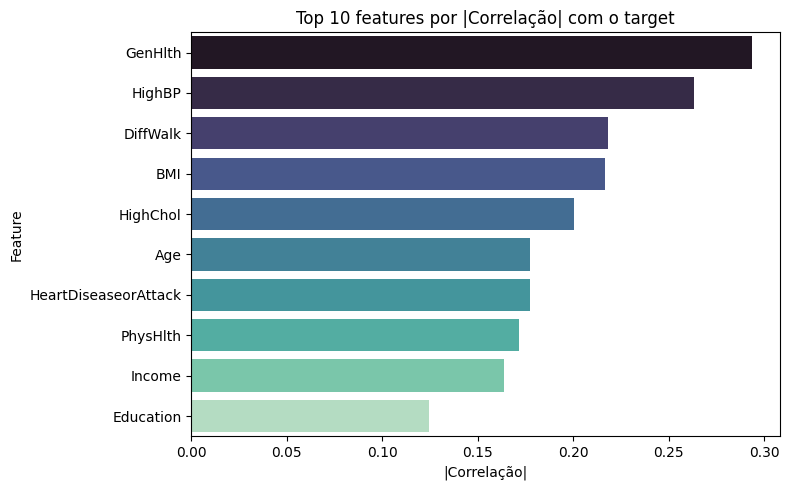

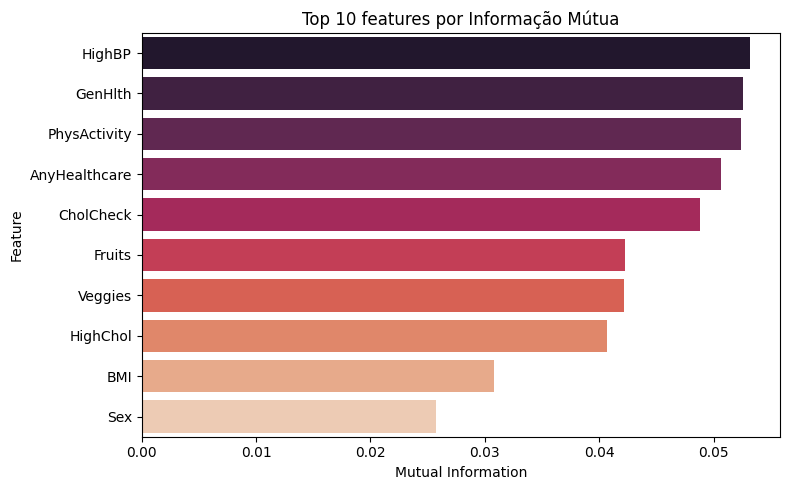


Variáveis-chave selecionadas:
['GenHlth', 'HighBP', 'HighChol', 'BMI', 'PhysActivity']


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

# --- 1. Preparar X e y ---
X = df.drop(columns='Diabetes_binary')
y = df['Diabetes_binary']

# --- 2. Correlação univariada com o target ---
corr_target = X.corrwith(y).abs().sort_values(ascending=False)
df_corr = corr_target[:10].reset_index().rename(columns={'index':'Feature', 0:'AbsCorr'})

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_corr,
    x='AbsCorr',
    y='Feature',
    hue='Feature',
    palette='mako',
    dodge=False,
    legend=False
)
plt.title("Top 10 features por |Correlação| com o target")
plt.xlabel("|Correlação|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
df_mi = mi_series[:10].reset_index().rename(columns={'index':'Feature', 0:'MI'})

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_mi,
    x='MI',
    y='Feature',
    hue='Feature',
    palette='rocket',
    dodge=False,
    legend=False
)
plt.title("Top 10 features por Informação Mútua")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- 4. Seleção final de variáveis-chave ---
# Combina ambos os rankings para determinar , por exemplo, as 5 com melhor média de posição
rank_corr = corr_target.rank(ascending=False)
rank_mi   = mi_series.rank(ascending=False)
mean_rank = (rank_corr + rank_mi) / 2
feat_key = mean_rank.sort_values().index[:5].tolist()

print("\nVariáveis-chave selecionadas:")
print(feat_key)


# Análise de Seleção de Variáveis-Chave

## 1. Correlação com o Target
- **Top 5 por |Correlação|**  
  1. **GenHlth** (≈ 0.30)  
  2. **HighBP** (≈ 0.25)  
  3. **DiffWalk** (≈ 0.22)  
  4. **BMI** (≈ 0.21)  
  5. **HighChol** (≈ 0.20)  

**Interpretação:**  
GenHlth (autoavaliação do estado de saúde) é o preditor mais linearmente associado ao risco de diabetes, seguido de fatores clínicos clássicos (hipertensão e IMC).

---

## 2. Informação Mútua com o Target
- **Top 5 por Mutual Information**  
  1. **HighBP**  
  2. **GenHlth**  
  3. **PhysActivity**  
  4. **AnyHealthcare**  
  5. **CholCheck**  

**Interpretação:**  
Além de HighBP e GenHlth, que também aparecem no ranking de correlação, o MI evidencia variáveis comportamentais e de acesso à saúde (atividade física, cobertura de saúde, checagem de colesterol) com dependências possivelmente não-lineares com o diagnóstico.

---

## 3. Variáveis-Chave Selecionadas
Combinando ambos os rankings (média de posição), as **5 features** escolhidas foram:
---
['GenHlth', 'HighBP', 'HighChol', 'BMI', 'PhysActivity']


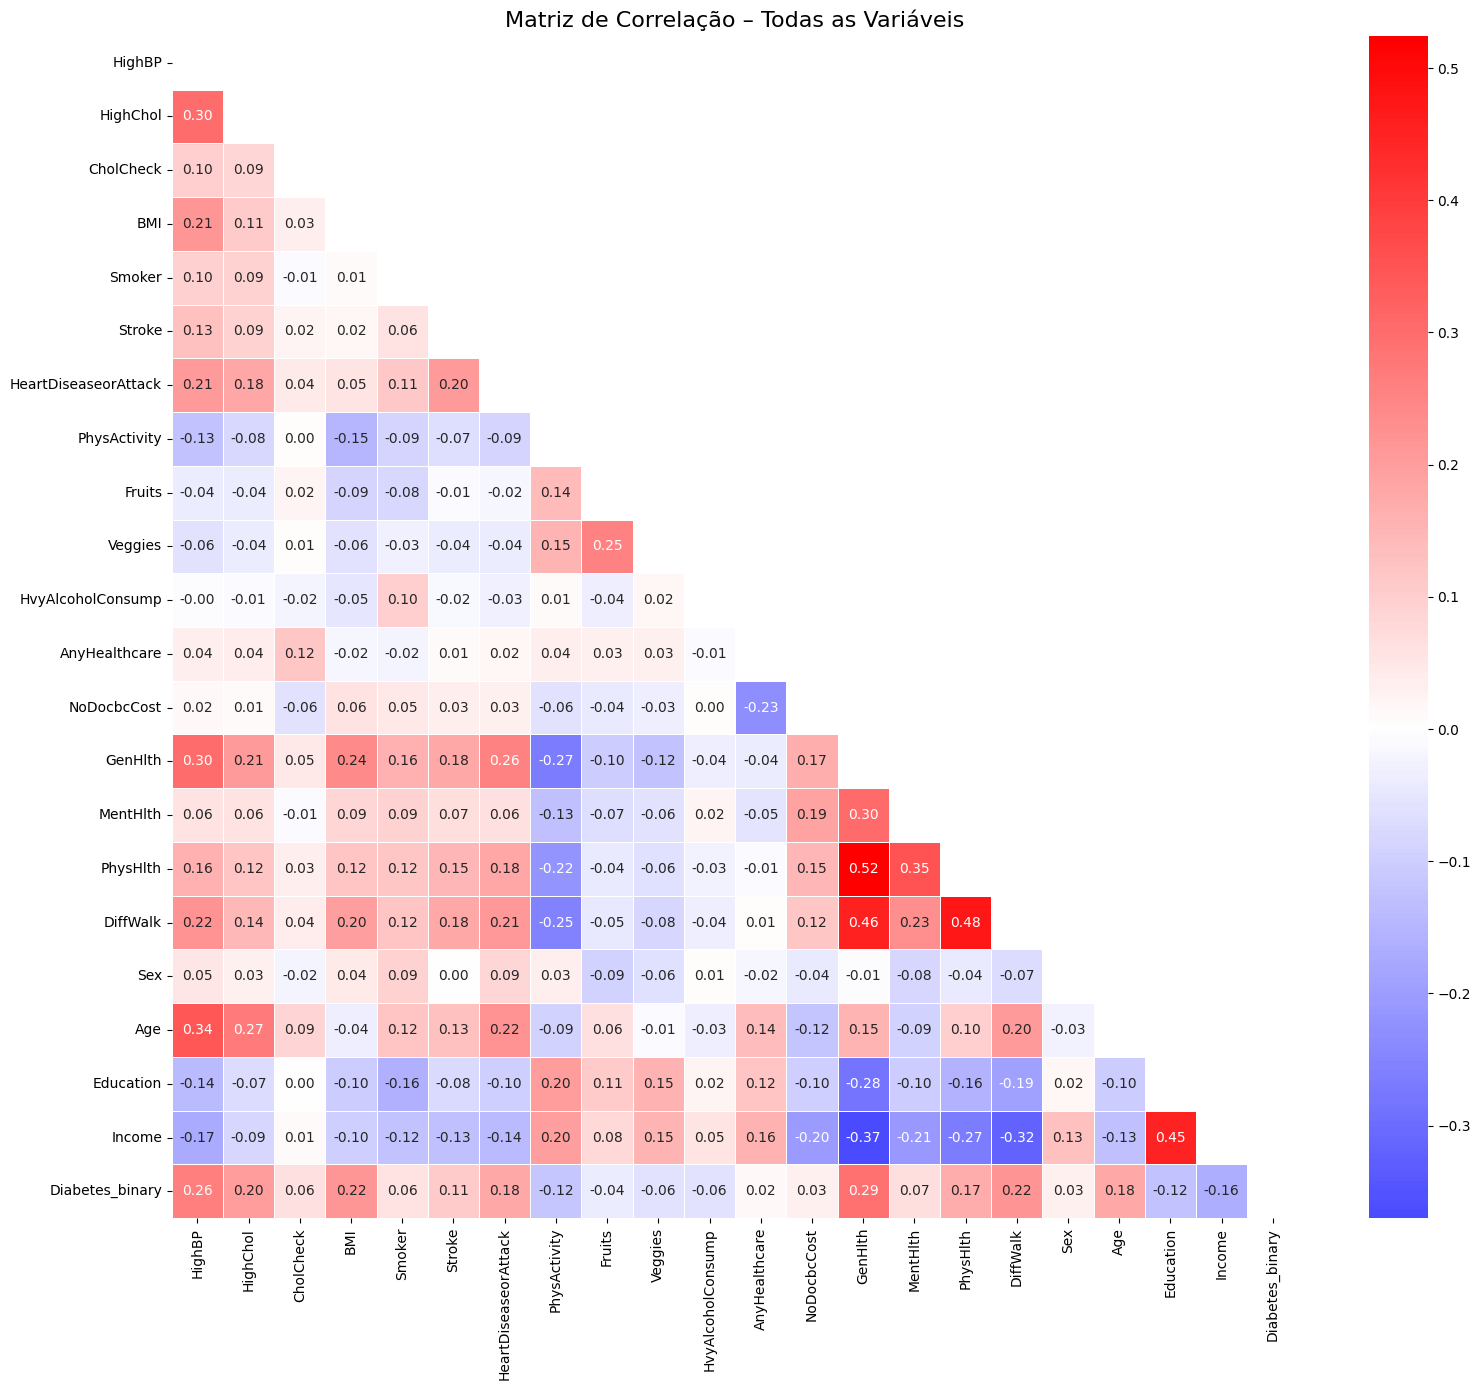

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1) Calcular matriz de correlação entre todas as variáveis (incluindo o target, se desejar)
corr_matrix = df.corr()

# 2) Criar máscara para triângulo superior (opcional, melhora a leitura)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 3) Plotar heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    mask=mask,            # esconde o triângulo superior
    annot=True,           # exibe coeficientes
    fmt=".2f",            # formato de duas casas decimais
    cmap="bwr",           # gradiente azul-vermelho
    center=0,             # centra o gradiente em zero
    linewidths=0.5
)
plt.title("Matriz de Correlação – Todas as Variáveis", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Análise da Matriz de Correlação e Implicações

### Principais Observações

1. **Correlações Moderadas com o Target**  
   - As maiores associações lineares com Diabetes_binary são:  
     - GenHlth (≈ 0.29)  
     - HighBP (≈ 0.20)  
     - BMI (≈ 0.22)  
     - Outras variáveis apresentam correlações abaixo de 0.20, indicando sinal fraco.

2. **Multicolinearidade Entre Features**  
   - PhysHlth × MentHlth ≈ 0.52  
   - PhysHlth × DiffWalk ≈ 0.48  
   - Income × Education ≈ 0.45  
   - Esses pares reforçam que algumas variáveis carregam informação duplicada.

3. **Correlação Negativa Relevante**  
   - PhysActivity × GenHlth ≈ –0.27  
   - Sinaliza que níveis mais altos de atividade física tendem a associar-se a melhor autoavaliação de saúde.

## Consequências para o Pipeline de Modelagem

1. **Seleção/Redução de Features**  
   - Variáveis altamente correlacionadas podem inflar a complexidade sem ganho real de performance.  
   - Aplique técnicas como PCA ou elimine um dos pares (por exemplo, manter apenas PhysHlth e remover MentHlth).

2. **Regularização em Modelos Lineares**  
   - Ridge/Lasso ajudam a penalizar coeficientes de features multicolineares, reduzindo overfitting.

3. **Features com Baixa Correlação**  
   - Muitas variáveis têm correlação quase zero com o target – cuidado para não “poluir” o modelo.  
   - Considere VarianceThreshold e avaliação baseada em importância (feature importance ou MI).

4. **Escalonamento e Engenharia de Features**  
   - Continuar com StandardScaler para equalizar amplitudes.  
   - Criar interações ou transformações (e.g., agrupar faixas de Age) pode revelar padrões não lineares.

5. **Limites de Performance**  
   - Como as correlações individuais são baixas, é improvável que um único modelo linear alcance alta acurácia.  
   - É recomendável testar modelos não lineares e ensemble (RF, XGBoost) que capturem interações complexas.

# Tratamento de Dados (Pré-Processamento) – Pipeline Genérico

Agora que as analises foram realizadas vamos preparar os dados de forma **agnóstica ao modelo**, aplicando:

1. **Split Estratificado**  
2. **Imputação** (mesmo sem NAs, para robustez)  
3. **Escalonamento** (StandardScaler)  
4. **Remoção de Baixa Variância**  
5. **Seleção de Features** (remoção de multicolinearidade/VarianceThreshold)  
6. **Balanceamento de Classes** (SMOTE ou pesos de classe)  


In [18]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression

# 1) Carregar dados
cdc = fetch_ucirepo(id=891)
X = cdc.data.features
y = cdc.data.targets.squeeze()

# 2) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Pipeline de pré-processamento
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # garante robustez
    ('scaler', StandardScaler()),                     # padroniza amplitudes
    ('var_thresh', VarianceThreshold(threshold=0.01)) # remove variáveis de baixa variância
])

# 4) Pipeline final com class_weight
pipeline = Pipeline([
    ('pp', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',  # equilibra as classes internamente
        random_state=42,
        max_iter=1000
    ))
])

# 5) Treinar e avaliar
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
print(f"Acurácia no teste: {score:.4f}")


Acurácia no teste: 0.7315


In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1) Carregar dados e selecionar features-chave
cdc = fetch_ucirepo(id=891)
X = cdc.data.features[['GenHlth','HighBP','HighChol','BMI','PhysActivity']]
y = cdc.data.targets.squeeze()

# 2) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Combinar X_train e y_train para resampling manual
train_df = pd.concat([X_train, y_train.rename('Diabetes_binary')], axis=1)

# 4) Separar majoritária e minoritária
df_major = train_df[train_df.Diabetes_binary==0]
df_minor = train_df[train_df.Diabetes_binary==1]

# 5) Upsample da minoritária para igualar a majoritária
df_minor_upsampled = resample(
    df_minor,
    replace=True,
    n_samples=len(df_major),
    random_state=42
)

# 6) Recombinar e embaralhar
train_balanced = pd.concat([df_major, df_minor_upsampled])
train_balanced = train_balanced.sample(frac=1, random_state=42)

X_train_bal = train_balanced.drop(columns='Diabetes_binary')
y_train_bal = train_balanced['Diabetes_binary']

print("Distribuição após upsampling:", 
      y_train_bal.value_counts().to_dict())

# 7) Pipeline de pré-processamento e modelo
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('var_thresh', VarianceThreshold(threshold=0.01)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# 8) Treinar e avaliar
pipeline.fit(X_train_bal, y_train_bal)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


Distribuição após upsampling: {0: 174667, 1: 174667}
              precision    recall  f1-score   support

           0     0.9441    0.7146    0.8135     43667
           1     0.2953    0.7386    0.4219      7069

    accuracy                         0.7180     50736
   macro avg     0.6197    0.7266    0.6177     50736
weighted avg     0.8537    0.7180    0.7589     50736

